# Image Captioning with CNN + Cuustom Transformer

This notebook implements an image captioning system using a CNN-Transformer architecture. The system consists of two main components:
1. A CNN (ResNet-50) encoder that extracts features from images
2. A Custom Transformer decoder that generates captions based on these features inspired by LukeDitria
https://github.com/LukeDitria/pytorch_tutorials/blob/main/section14_transformers/solutions/Pytorch5_Transformer_Image_Captioning.ipynb

## Environment Setup and Dependencies

First, we'll import all necessary libraries:
- PyTorch for deep learning
- torchvision for image processing and pretrained models
- transformers for tokenization
- pycocotools for working with the COCO dataset
- Various utility libraries for data handling and visualization


In [1]:
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from tqdm.notebook import trange
import tqdm
import random

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset,  DataLoader
import torch.nn.functional as F
from torch.distributions import Categorical
from pycocotools.coco import COCO
from PIL import Image

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision

# HugginFace's transformers library 
from transformers import AutoTokenizer
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# For Calculating Metric
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.cider.cider import Cider
from nltk.tokenize import word_tokenize
import json
import time

# For Model Summary
from torchinfo import summary

torch.backends.cuda.matmul.allow_tf32 = True

## Dataset Configuration and Loading

Here we define the CocoDataset class and set up data loading pipeline:

1. **CocoDataset Class**: 
   - Custom PyTorch Dataset class for handling COCO data
   - Loads image-caption pairs from the COCO dataset
   - Applies necessary transformations to images

2. **Data Transformations**:
   - Training: Includes data augmentation (random cropping, random erasing)
   - Validation: Basic resizing and normalization only

3. **DataLoader Configuration**:
   - Batch processing setup
   - Shuffling for training data
   - Proper normalization using ImageNet statistics

4. **Model Configuration Parameters**
    - Learning Rate
    - Image Size
    - Number of Epoch
    - Batch Size
    - Number of transformer decoder layer
    - Number of head in multi-head attention

In [2]:
# Configuration parameters
learning_rate = 1e-4
image_size = 224
nepochs = 30
batch_size = 32
hidden_size = 512
num_decoder_layers = 6
num_heads = 8

# Dataset paths
data_set_root='../coco_captions'
train_set ='train2017'
validation_set ='val2017'

# train_image_path = os.path.join(data_set_root, train_set)
train_image_path = '../coco_captions/train2017'
train_ann_file = '{}/annotations/captions_{}.json'.format(data_set_root, train_set)

val_image_path = os.path.join(data_set_root, validation_set)
val_ann_file = '{}/annotations/captions_{}.json'.format(data_set_root, validation_set)

print(f"Train Image path: {train_image_path}")
print(f"Train annotation path: {train_ann_file}")
print(f"Val annotation path: {val_ann_file}")

Train Image path: ../coco_captions/train2017
Train annotation path: ../coco_captions/annotations/captions_train2017.json
Val annotation path: ../coco_captions/annotations/captions_val2017.json


## Datasets

### 1. CocoDataset Class

In [3]:
class CocoDataset(Dataset):
    def __init__(self, root_dir, ann_file, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images
            ann_file (string): Path to annotation file
            transform: Transform pipeline for images
        """
        self.root_dir = root_dir
        self.transform = transform
        self.coco = COCO(ann_file)
        self.ids = list(self.coco.anns.keys())

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        """Returns one data pair (image and caption)."""
        ann_id = self.ids[idx]
        caption = self.coco.anns[ann_id]['caption']
        img_id = self.coco.anns[ann_id]['image_id']
        path = self.coco.loadImgs(img_id)[0]['file_name']

        # Load and transform image
        image = Image.open(os.path.join(self.root_dir, path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        return image, caption, img_id

### 2. Data Loading and Processing

In [4]:
train_transform = transforms.Compose([transforms.Resize((256, 256)),  # Larger size for random cropping
                                      transforms.RandomCrop((224, 224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225]),
                                      transforms.RandomErasing(p=0.5)]) 

transform = transforms.Compose([transforms.Resize((224, 224)),  # No random cropping during validation
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])]) 

# Create datasets
train_dataset = CocoDataset(
    root_dir=train_image_path,
    ann_file=train_ann_file,
    transform=train_transform,
) 

val_dataset = CocoDataset(
    root_dir=val_image_path,
    ann_file=val_ann_file,
    transform=transform,
)

data_loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
data_loader_val = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

loading annotations into memory...
Done (t=0.65s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


### 3. Visualize Data

In [5]:
# Create a dataloader itterable object
dataiter = next(iter(data_loader_val))
# Sample from the itterable object
test_images, test_captions, test_img_ids = dataiter

a large computer set up with a desktop computer, laptop, and printer.


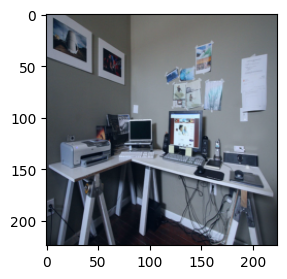

In [6]:
# Lets visualise a snippet of a batch of images and captions
plt.figure(figsize = (3,3))
out = torchvision.utils.make_grid(test_images[0:1], 1, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

caption = test_captions[0]
print(caption)

In [7]:
# Visualize the captions in a batch
print(test_captions)

('a large computer set up with a desktop computer, laptop, and printer.', "A cat playing with it's reflection in a mirror.", 'Two giraffes walking along a trail to the hills.', 'A yellow bus waiting at bus stop near some benches.', 'A wooden bench sitting in front of a store.', 'Several breakfast foods are on top of a refrigerator.', 'A group of zebras are crossing a stream.', 'The cat is setting in front of the TV.', 'A woman holding a child wrapped in a towel brushing her teeth.', 'In bathroom taking selfie of herself brushing teeth.', 'A woman tennis player serving a tennis ball.', 'An unattended office containing several computers and a chair.', 'A woman walking past a store front on the sidewalk.', 'A girl smiles while holding a baseball glove.', 'Two baseball players standing in a field surrounded by a fence.', 'a man that is on a skateboard on a rail', 'A dog sits on top of a bed in a room.', 'A woman in a red jacket skiing down a slope', 'A couple of elephants standing in the g

Visualizing all images in the batch:


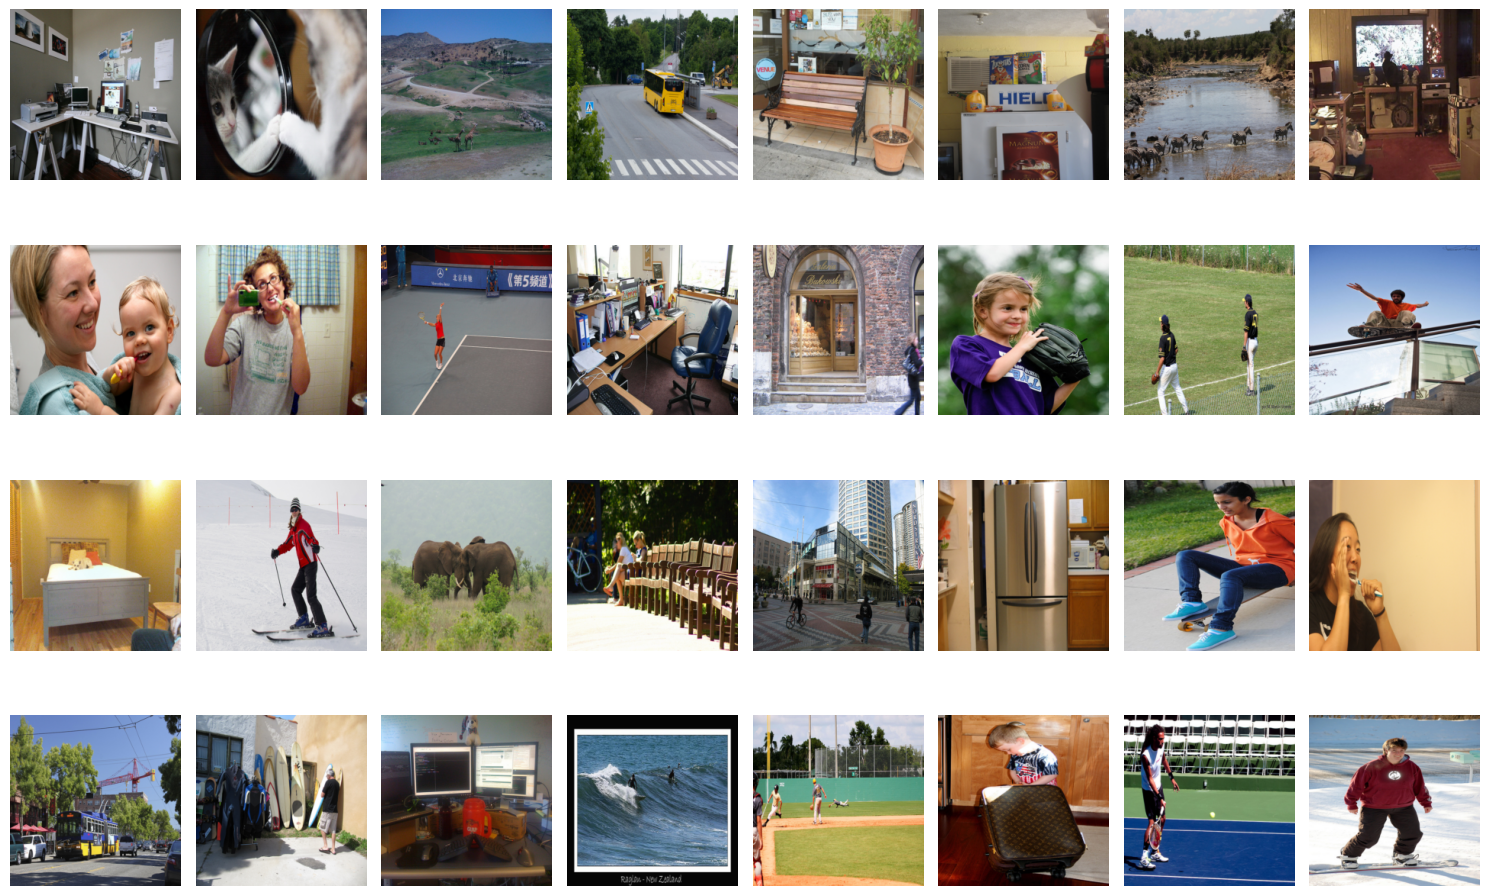

In [8]:
# Unnormalize the images for visualization
def unnormalize_image(img):
    mean = torch.tensor([0.485, 0.456, 0.406], device=img.device)
    std = torch.tensor([0.229, 0.224, 0.225], device=img.device)
    img = img.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
    img = img * std + mean  # Unnormalize
    img = img.cpu().numpy()  # Convert to a NumPy array for visualization
    img = img.clip(0, 1)  # Clip to valid range
    return img

# Visualize the images in the batch
print("Visualizing all images in the batch:")
plt.figure(figsize=(15, 10))
for i in range(len(test_images)):
    plt.subplot(4, 8, i + 1)  # Adjust the grid size if needed
    plt.imshow(unnormalize_image(test_images[i]))
    plt.axis('off')
plt.tight_layout()
plt.show()


In [9]:
# Visualize it in tensor form
print(test_images)

tensor([[[[ 0.2453,  0.2453,  0.2282,  ..., -0.4054, -0.3712, -0.3369],
          [ 0.2624,  0.2453,  0.2453,  ..., -0.3712, -0.3712, -0.3712],
          [ 0.2796,  0.2453,  0.2796,  ..., -0.3712, -0.3541, -0.3883],
          ...,
          [-1.6898, -1.6555, -1.6384,  ..., -1.3644, -1.3987, -1.4329],
          [-1.6898, -1.6727, -1.6384,  ..., -1.3815, -1.3987, -1.3987],
          [-1.6898, -1.6898, -1.6727,  ..., -1.3815, -1.3987, -1.3644]],

         [[ 0.3452,  0.3627,  0.3627,  ..., -0.2850, -0.3200, -0.3025],
          [ 0.3627,  0.3803,  0.3803,  ..., -0.2675, -0.3025, -0.2850],
          [ 0.3803,  0.3627,  0.4153,  ..., -0.2850, -0.2500, -0.2500],
          ...,
          [-1.5455, -1.5455, -1.5280,  ..., -1.2479, -1.3004, -1.3354],
          [-1.5455, -1.5630, -1.5455,  ..., -1.2479, -1.2829, -1.3179],
          [-1.5805, -1.5980, -1.5980,  ..., -1.2654, -1.3179, -1.3354]],

         [[ 0.5834,  0.6182,  0.6008,  ..., -0.2707, -0.2881, -0.2707],
          [ 0.5834,  0.6356,  

Displaying 3 random samples from the dataset...

Sample 1:
--------------------------------------------------------------------------------


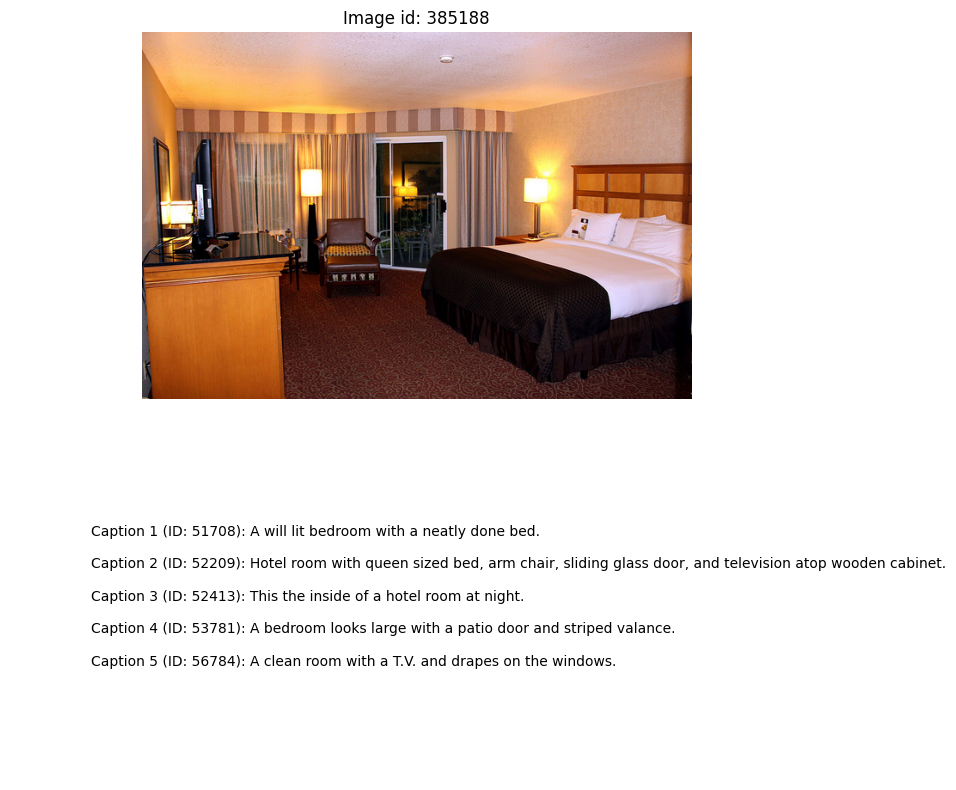


Sample 2:
--------------------------------------------------------------------------------


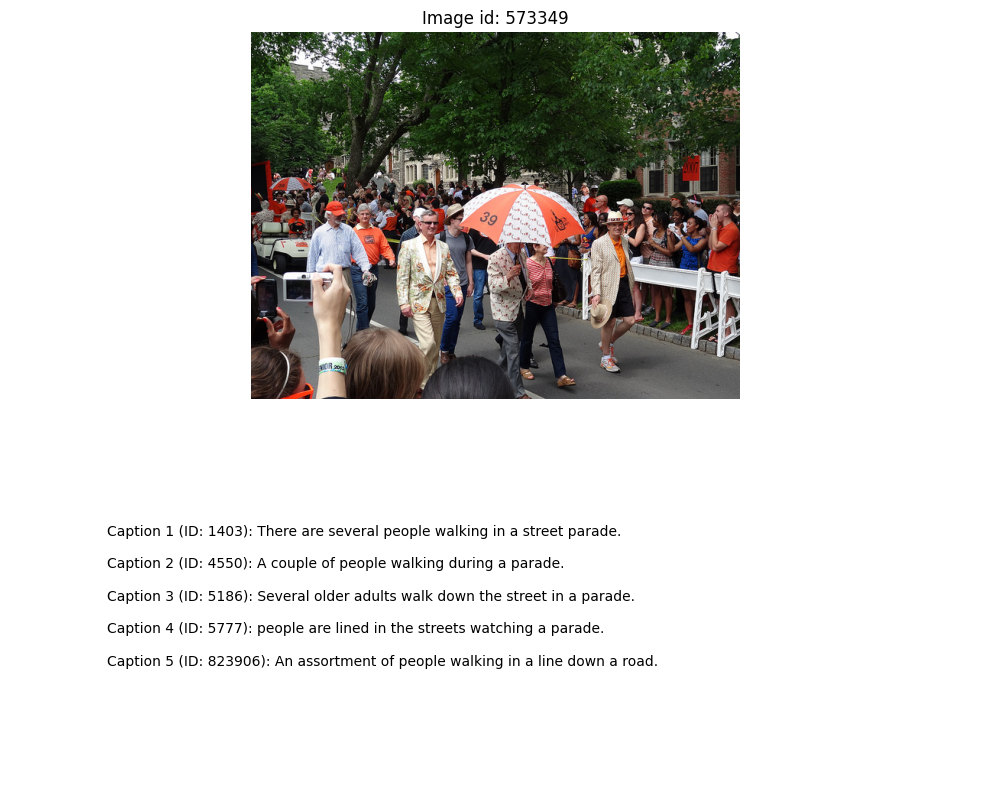


Sample 3:
--------------------------------------------------------------------------------


C:\Users\Irfaan\AppData\Local\Temp\ipykernel_18356\677278544.py:47: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


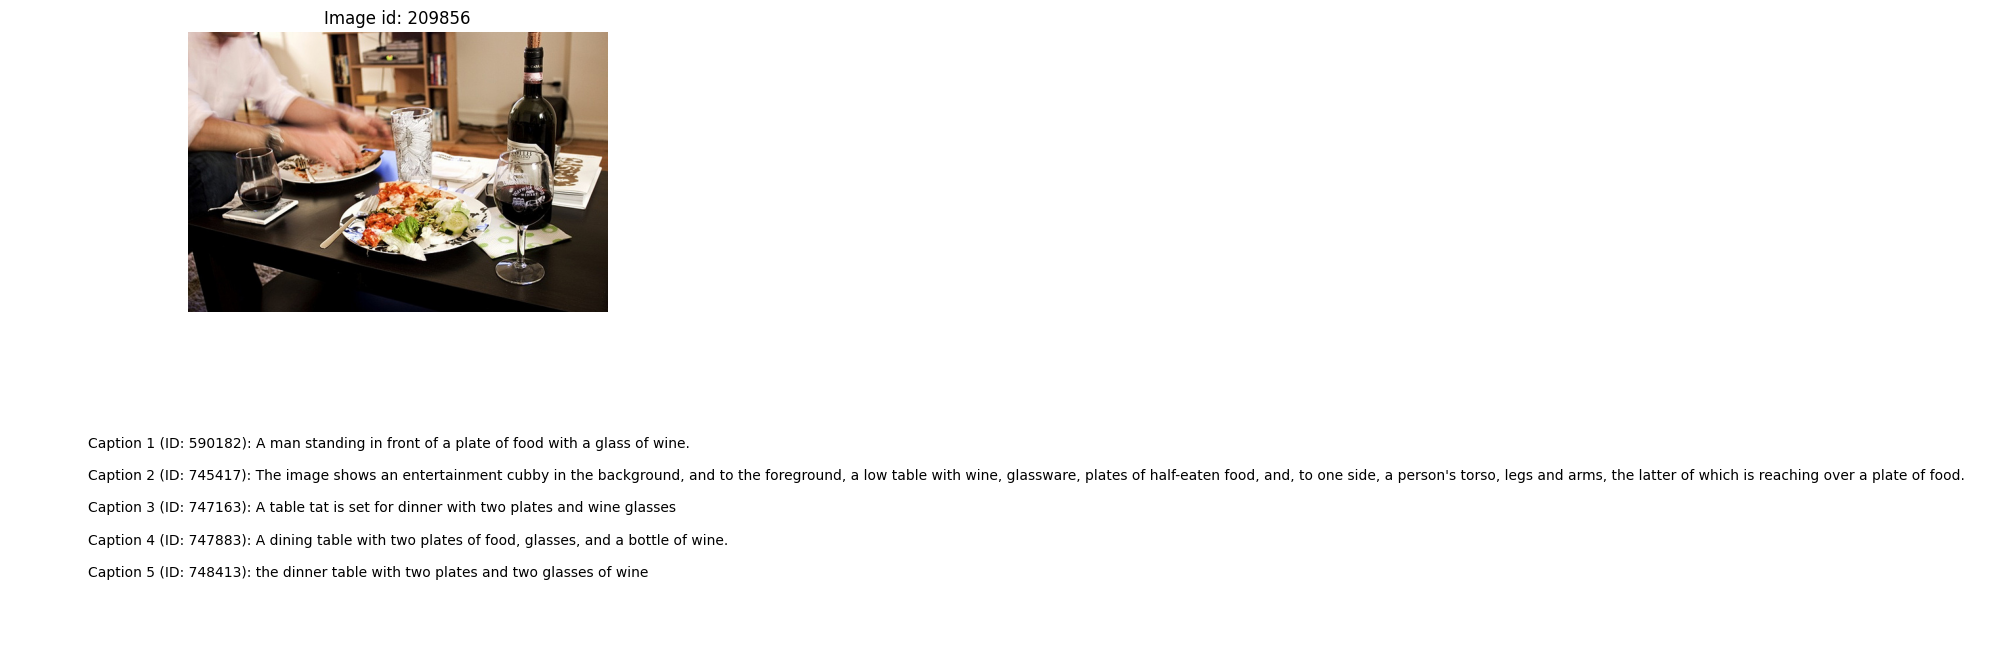

In [15]:
def display_dataset_samples(dataset, num_samples=3):
    """
    Display multiple random samples from the dataset with their captions.

    Args:
        dataset: CocoDataset instance
        num_samples: Number of samples to display
    """
    coco_caps = dataset.coco
    root_dir = dataset.root_dir

    print(f"Displaying {num_samples} random samples from the dataset...")

    for i in range(num_samples):
        print(f"\nSample {i+1}:")
        print("-" * 80)

        # Get a random image ID
        img_ids = coco_caps.getImgIds()
        img_id = random.choice(img_ids)

        # Load image info
        img_info = coco_caps.loadImgs([img_id])[0]

        # Load image using PIL
        img_path = os.path.join(root_dir, img_info['file_name'])
        image = Image.open(img_path).convert('RGB')

        # Get and display captions
        ann_ids = coco_caps.getAnnIds(imgIds=img_id)
        anns = coco_caps.loadAnns(ann_ids)

        # Create text display for captions
        caption_text = '\n\n'.join([f"Caption {i+1} (ID: {ann['id']}): {ann['caption']}"
                                   for i, ann in enumerate(anns)])

        # Display image and captions
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
        ax1.imshow(image)
        ax1.axis('off')
        ax1.set_title('Image id: ' + str(img_id))
        ax2.text(0.1, 0.5, caption_text,
                 wrap=True,
                 verticalalignment='center',
                 fontsize=10)
        ax2.axis('off')
        plt.tight_layout()
        plt.show()

# Display some samples from the training dataset
display_dataset_samples(train_dataset, num_samples=3)

## Tokenization Configuration

We use the DistilBERT tokenizer for processing text:
1. Initialize the tokenizer
2. Test tokenization on sample captions
3. Verify token sequences and vocabulary size
4. Display tokenized outputs for understanding the text preprocessing

This helps us understand how captions are converted into a format suitable for the Transformer decoder.

In [10]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [11]:
tokenizer.vocab_size

30522

In [12]:
# Let's test with one caption
sample_caption = test_captions[0]
print("\nSample caption:", sample_caption)
# Ensure  `test_captions` is a list of strings
test_captions_list = [caption for caption in test_captions]


Sample caption: a large computer set up with a desktop computer, laptop, and printer.


In [13]:
tokens = tokenizer(test_captions_list, padding=True, truncation=True, return_tensors="pt")

# Batch size x sequence length
print(tokens['input_ids'])
print(len(tokens['input_ids']))

# Sequence length
print(tokens['input_ids'][0])
print(len(tokens['input_ids'][0]))

# print the length of all the captions in a batch
for i in range(len(tokens['input_ids'])):
    print(len(tokens['input_ids'][i]), end=', ')

tensor([[  101,  1037,  2312,  3274,  2275,  2039,  2007,  1037, 15363,  3274,
          1010, 12191,  1010,  1998, 15041,  1012,   102],
        [  101,  1037,  4937,  2652,  2007,  2009,  1005,  1055,  9185,  1999,
          1037,  5259,  1012,   102,     0,     0,     0],
        [  101,  2048, 21025, 27528,  7959,  2015,  3788,  2247,  1037,  4446,
          2000,  1996,  4564,  1012,   102,     0,     0],
        [  101,  1037,  3756,  3902,  3403,  2012,  3902,  2644,  2379,  2070,
         19571,  1012,   102,     0,     0,     0,     0],
        [  101,  1037,  4799,  6847,  3564,  1999,  2392,  1997,  1037,  3573,
          1012,   102,     0,     0,     0,     0,     0],
        [  101,  2195,  6350,  9440,  2024,  2006,  2327,  1997,  1037, 18097,
          1012,   102,     0,     0,     0,     0,     0],
        [  101,  1037,  2177,  1997, 29145,  2015,  2024,  5153,  1037,  5460,
          1012,   102,     0,     0,     0,     0,     0],
        [  101,  1996,  4937,  200

In [14]:
print(tokenizer.decode(tokens['input_ids'][0]))

[CLS] a large computer set up with a desktop computer, laptop, and printer. [SEP]


In [16]:
class TokenDrop(nn.Module):
    """
    For a batch of tokens indices, randomly replace a non-specical token.
    
    Args:
        prob (float): probability of dropping a token
        blank_token (int): index for the blank token
    """

    def __init__(self, prob=0.1, blank_token=1, eos_token=102):
        self.prob = prob
        self.eos_token = eos_token
        self.blank_token = blank_token

    def __call__(self, sample):
        # Randomly sample a bernoulli distribution with p=prob
        # to create a mask where 1 means we will replace that token
        mask = torch.bernoulli(self.prob * torch.ones_like(sample)).long()
        
        # only replace if the token is not the eos token
        can_drop = (~(sample == self.eos_token)).long()
        mask = mask * can_drop
        
        # Do not replace the sos tokens
        mask[:, 0] = torch.zeros_like(mask[:, 0]).long()
        
        replace_with = (self.blank_token * torch.ones_like(sample)).long()
        
        sample_out = (1 - mask) * sample + mask * replace_with
        
        return sample_out

## Model Architecture Definition

The model architecture consists of four main components:

### 1. EncoderCNN
- Uses a pretrained ResNet-50 backbone
- Removes classification layers and one convolutional layer
- Adds a pointwise convolution reduction layer
- Freezes ResNet parameters for transfer learning
- Outputs spatial features (batch_size × num_pixels × hidden_size)

### 2. SinusoidalPosEmb
- Implements sinusoidal positional encoding
- Adds positional information to token embeddings
- Helps model understand sequence order

### 3. AttentionBlock
- Multi-head attention for feature processing

### 4. TransformerBlock
- A transformer block with self-attention
- Causal masking for autoregressive generation

### 5. Decoder
- Embedding layer for converting token IDs to vectors
- Standard Transformer decoder architecture
- Output layer for vocabulary prediction

### 6. TransformerImageCaptioningModel
- Combines EncoderCNN and TransformerDecoder
- Handles end-to-end image captioning


In [17]:
# CNN Encoder
class CNNEncoder(nn.Module):
    def __init__(self, hidden_size=512):
        super(CNNEncoder, self).__init__()
        resnet = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        self.conv_reduce = nn.Conv2d(2048, hidden_size, kernel_size=1)
        
        for param in self.resnet.parameters():
            param.requires_grad = False
            
    def forward(self, images):
        features = self.resnet(images)
        features = self.conv_reduce(features)
        batch_size, hidden_size, h, w = features.shape
        features = features.permute(0, 2, 3, 1)
        features = features.view(batch_size, -1, hidden_size)
        return features

In [18]:
# sinusoidal positional embeds
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb
    

# Define a module for attention blocks
class AttentionBlock(nn.Module):
    def __init__(self, hidden_size=128, num_heads=4, masking=True):
        super(AttentionBlock, self).__init__()
        self.masking = masking

        # Multi-head attention mechanism
        self.multihead_attn = nn.MultiheadAttention(hidden_size,
                                                    num_heads=num_heads,
                                                    batch_first=True,
                                                    dropout=0.0)

    def forward(self, x_in, kv_in, key_mask=None):
        # Apply causal masking if enabled
        if self.masking:
            bs, l, h = x_in.shape
            mask = torch.triu(torch.ones(l, l, device=x_in.device), 1).bool()
        else:
            mask = None
            
        # Perform multi-head attention operation
        return self.multihead_attn(x_in, kv_in, kv_in, attn_mask=mask, 
                                   key_padding_mask=key_mask)[0]


# Define a module for a transformer block with self-attention 
# and optional causal masking
class TransformerBlock(nn.Module):
    def __init__(self, hidden_size=128, num_heads=4, decoder=False, masking=True):
        super(TransformerBlock, self).__init__()
        self.decoder = decoder

        # Layer normalization for the input
        self.norm1 = nn.LayerNorm(hidden_size)
        # Self-attention mechanism
        self.attn1 = AttentionBlock(hidden_size=hidden_size, num_heads=num_heads, 
                                    masking=masking)
        
        # Layer normalization for the output of the first attention layer
        if self.decoder:
            self.norm2 = nn.LayerNorm(hidden_size)
            # Self-attention mechanism for the decoder with no masking
            self.attn2 = AttentionBlock(hidden_size=hidden_size, 
                                        num_heads=num_heads, masking=False)
        
        # Layer normalization for the output before the MLP
        self.norm_mlp = nn.LayerNorm(hidden_size)
        # Multi-layer perceptron (MLP)
        self.mlp = nn.Sequential(nn.Linear(hidden_size, hidden_size * 4),
                                 nn.ELU(),
                                 nn.Linear(hidden_size * 4, hidden_size))
                
    def forward(self, x, input_key_mask=None, cross_key_mask=None, kv_cross=None):
        # Perform self-attention operation
        x = self.attn1(x, x, key_mask=input_key_mask) + x
        x = self.norm1(x)

        # If decoder, perform additional cross-attention layer
        if self.decoder:
            x = self.attn2(x, kv_cross, key_mask=cross_key_mask) + x
            x = self.norm2(x)

        # Apply MLP and layer normalization
        x = self.mlp(x) + x
        return self.norm_mlp(x)

    
# Define a decoder module for the Transformer architecture
class Decoder(nn.Module):
    def __init__(self, num_emb, hidden_size=128, num_layers=3, num_heads=4):
        super(Decoder, self).__init__()
        
        # Create an embedding layer for tokens
        self.embedding = nn.Embedding(num_emb, hidden_size)
        # Initialize the embedding weights
        self.embedding.weight.data = 0.001 * self.embedding.weight.data

        # Initialize sinusoidal positional embeddings
        self.pos_emb = SinusoidalPosEmb(hidden_size)
        
        # Create multiple transformer blocks as layers
        self.blocks = nn.ModuleList([
            TransformerBlock(hidden_size, num_heads, 
                             decoder=True) for _ in range(num_layers)
        ])
                
        # Define a linear layer for output prediction
        self.fc_out = nn.Linear(hidden_size, num_emb)
        
    def forward(self, input_seq, encoder_output, input_padding_mask=None, 
                encoder_padding_mask=None):        
        # Embed the input sequence
        input_embs = self.embedding(input_seq)
        bs, l, h = input_embs.shape

        # Add positional embeddings to the input embeddings
        seq_indx = torch.arange(l, device=input_seq.device)
        pos_emb = self.pos_emb(seq_indx).reshape(1, l, h).expand(bs, l, h)
        embs = input_embs + pos_emb
        
        # Pass the embeddings through each transformer block
        for block in self.blocks:
            embs = block(embs, 
                           input_key_mask=input_padding_mask, 
                           cross_key_mask=encoder_padding_mask, 
                           kv_cross=encoder_output)
        
        return self.fc_out(embs)

In [19]:
# Define an Image Captioning Encoder-Decoder module with the Transformer architecture
class TransformerImageCaptioningModel(nn.Module):
    def __init__(self, image_size, channels_in, num_emb, 
                 hidden_size=128, num_layers=6, num_heads=4):
        super(TransformerImageCaptioningModel, self).__init__()

        self.encoder = CNNEncoder(hidden_size=hidden_size)
        
        self.decoder = Decoder(num_emb=num_emb, hidden_size=hidden_size, 
                               num_layers=num_layers, num_heads=num_heads)

    def forward(self, input_image, target_seq, padding_mask):
        # Generate padding masks for the target sequence
        bool_padding_mask = padding_mask == 0

        # Encode the input sequence
        encoded_seq = self.encoder(images=input_image)
        
        # Decode the target sequence using the encoded sequence
        decoded_seq = self.decoder(input_seq=target_seq, 
                                   encoder_output=encoded_seq, 
                                   input_padding_mask=bool_padding_mask)
        return decoded_seq

## Model Initialization 
- Sets up hyperparameters (embed size, hidden size, etc.)
- Initializes model components
- Configures loss function and optimizer
- Prepares for training on specified device

In [20]:
# Set the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create model
caption_model = TransformerImageCaptioningModel(image_size=image_size, channels_in=test_images.shape[1], 
                                     num_emb=tokenizer.vocab_size, 
                                     num_layers=num_decoder_layers,hidden_size=hidden_size, 
                                     num_heads=num_heads).to(device)

# Initialize the optimizer with above parameters
optimizer = optim.Adam(caption_model.parameters(), lr=learning_rate)

scaler = torch.cuda.amp.GradScaler()

# Define the loss function
loss_fn = nn.CrossEntropyLoss(reduction="none")

td = TokenDrop(0.5)

# Initialize the training loss logger
training_loss_logger = []

C:\Users\Irfaan\AppData\Local\Temp\ipykernel_18356\1063137238.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


## Training 

Implements a comprehensive training loop:

1. **Per Epoch**:
   - Training phase with gradient updates
   - Validation phase for performance monitoring
   - Progress bars for visual feedback
   - Metric calculation (loss and accuracy and bleu score using nltk)

2. **Features**:
   - Teacher forcing for stable training
   - Regular model checkpointing
   - Best model saving based on validation loss
   - Comprehensive logging of metrics

3. **Functions**
    - generate_caption
    - calculate_bleu_scores
    - train_model

In [22]:
def generate_caption(model, image, tokenizer, device, max_length=50, temperature=0.5):
    """Generate a caption for a single image using the provided model"""
    model.eval()
    
    # Add the Start-Of-Sentence token
    sos_token = 101 * torch.ones(1, 1).long()
    log_tokens = [sos_token]
    
    with torch.no_grad():
        # Encode the input image
        with torch.cuda.amp.autocast(enabled=False):
            image_embedding = model.encoder(image.unsqueeze(0).to(device))
        
        # Generate the caption tokens
        for _ in range(max_length):
            input_tokens = torch.cat(log_tokens, 1)
            
            # Decode the input tokens
            data_pred = model.decoder(input_tokens.to(device), image_embedding)
            
            # Sample from the distribution
            dist = Categorical(logits=data_pred[:, -1] / temperature)
            next_tokens = dist.sample().reshape(1, 1)
            
            # Append the next token
            log_tokens.append(next_tokens.cpu())
            
            # Break if End-Of-Caption token is predicted
            if next_tokens.item() == 102:
                break
    
    # Convert token list to tensor
    pred_text = torch.cat(log_tokens, 1)
    return pred_text[0]

In [23]:
def calculate_bleu_scores(model, data_loader, tokenizer, device, max_length=50, temperature=0.5):
    """Calculate BLEU scores for the model predictions using all available reference captions"""
    model.eval()
    references_dict = {}
    hypotheses_dict = {}
    
    with torch.no_grad():
        bleu_progress_bar = tqdm.tqdm(data_loader, desc='Calculating BLEU scores')
        for images, _, img_ids in bleu_progress_bar:
            images = images.to(device)
            
            # Generate captions for batch
            for i, img in enumerate(images):
                img_id = img_ids[i].item()
                
                # Generate caption for the image
                output_ids = generate_caption(model, img, tokenizer, device, max_length, temperature)
                predicted_caption = tokenizer.decode(output_ids, skip_special_tokens=True)
                
                # Get all reference captions for this image from COCO
                ann_ids = data_loader.dataset.coco.getAnnIds(imgIds=img_id)
                anns = data_loader.dataset.coco.loadAnns(ann_ids)
                reference_captions = [ann['caption'].lower() for ann in anns]
                
                # Process reference captions
                references = [word_tokenize(ref_cap) for ref_cap in reference_captions]
                hypothesis = word_tokenize(predicted_caption.lower())
                
                # Store using image_id as key
                references_dict[img_id] = references
                hypotheses_dict[img_id] = hypothesis
    
    # Calculate BLEU scores for different n-grams
    bleu_scores = {}
    weights = {
        'bleu-1': (1.0, 0, 0, 0),
        'bleu-2': (0.5, 0.5, 0, 0),
        'bleu-3': (0.33, 0.33, 0.33, 0),
        'bleu-4': (0.25, 0.25, 0.25, 0.25)
    }
    
    # Convert to format expected by corpus_bleu
    references = [references_dict[img_id] for img_id in hypotheses_dict.keys()]
    hypotheses = [hypotheses_dict[img_id] for img_id in hypotheses_dict.keys()]
    
    # Calculate corpus-level BLEU scores
    for metric, weight in weights.items():
        score = corpus_bleu(references, hypotheses, weights=weight)
        bleu_scores[metric] = score
    
    return bleu_scores

In [24]:
def train_model(model, train_loader, val_loader, loss_fn, optimizer, scaler, tokenizer, td, 
                num_epochs, device, save_dir='model_checkpoints'):
    # Create directory for saving models if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # Training phase
        start_time = time.time()
        model.train()
        total_train_loss = 0.0
        total_train_accuracy = 0.0
        train_steps = 0
        
        # Iterate over the training data loader
        train_progress_bar = tqdm.tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Training]')
        for images, captions, _ in train_progress_bar:
            images = images.to(device)

            # Tokenize captions
            captions_list = [caption for caption in captions]  # Convert tuple to list
            tokens = tokenizer(captions_list, padding=True, truncation=True, return_tensors="pt")
            token_ids = tokens['input_ids'].to(device)
            padding_mask = tokens['attention_mask'].to(device)
            
            # Shift the input sequence to create the target sequence
            target_ids = torch.cat((token_ids[:, 1:], 
                                  torch.zeros(token_ids.size(0), 1, device=device).long()), 1)
            
            tokens_in = td(token_ids)
            
            with torch.cuda.amp.autocast():
                # Forward pass - use same batch of images with different captions
                pred = model(images, tokens_in, padding_mask=padding_mask)

            # Compute the loss
            loss = (loss_fn(pred.transpose(1, 2), target_ids) * padding_mask).mean()

            # Calculate accuracy (excluding padding tokens)
            predictions = (pred.transpose(1, 2)).argmax(dim=1)
            correct = ((predictions == target_ids) * padding_mask).sum().item()
            total = padding_mask.sum().item()
            accuracy = correct / total if total > 0 else 0

            # Backpropagation
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # Update training metrics
            total_train_loss += loss.item()
            total_train_accuracy += accuracy
            train_steps += 1

            train_progress_bar.set_postfix({'train_loss': total_train_loss / train_steps, 'train_accuracy': total_train_accuracy / train_steps})
        
        avg_train_loss = total_train_loss / train_steps
        avg_train_accuracy = total_train_accuracy / train_steps
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_accuracy)
        
        # Validation phase
        model.eval()
        total_val_loss = 0.0
        total_val_accuracy = 0.0
        val_steps = 0
        
        val_progress_bar = tqdm.tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Validation]')
        with torch.no_grad():
            for images, captions, _ in val_progress_bar:
                images = images.to(device)
                
                # Tokenize captions
                captions_list = [caption for caption in captions]  # Convert tuple to list
                tokens = tokenizer(captions_list, padding=True, truncation=True, return_tensors="pt")
                token_ids = tokens['input_ids'].to(device)
                padding_mask = tokens['attention_mask'].to(device)
                
                target_ids = torch.cat((token_ids[:, 1:], 
                                      torch.zeros(token_ids.size(0), 1, device=device).long()), 1)
                
                tokens_in = td(token_ids)
                
                with torch.cuda.amp.autocast():
                    pred = model(images, tokens_in, padding_mask=padding_mask)
                
                loss = (loss_fn(pred.transpose(1, 2), target_ids) * padding_mask).mean()
                predictions = (pred.transpose(1, 2)).argmax(dim=1)
                correct = ((predictions == target_ids) * padding_mask).sum().item()
                total = padding_mask.sum().item()
                accuracy = correct / total if total > 0 else 0
                total_val_loss += loss.item()
                total_val_accuracy += accuracy
                val_steps += 1

                val_progress_bar.set_postfix({'val_loss': total_val_loss / val_steps, 'val_accuracy': total_val_accuracy / val_steps})
        
        avg_val_loss = total_val_loss / val_steps
        avg_val_accuracy = total_val_accuracy / val_steps
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_accuracy)
        
        # Save model checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint_path = os.path.join(save_dir, f'model_epoch_{epoch+1}.pth')
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'train_accuracies': train_accuracies,
                'val_accuracies': val_accuracies
            }, checkpoint_path)
            print(f"Checkpoint saved to {checkpoint_path}")
            
            # Calculate and print BLEU scores
            bleu_scores = calculate_bleu_scores(
                model=model,
                data_loader=val_loader,
                tokenizer=tokenizer,
                device=device,
                temperature=0.5
            )
            # Print the scores
            for metric, score in bleu_scores.items():
                print(f"{metric.upper()}: {score:.4f}")
                    
        # Save best model based on validation loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_path = os.path.join(save_dir, 'best_model.pth')
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': best_val_loss,
                'train_loss': avg_train_loss,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'train_accuracies': train_accuracies,
                'val_accuracies': val_accuracies
            }, best_model_path)
        
        # Print epoch summary
        epoch_time = time.time() - start_time
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f'Time: {epoch_time:.2f}s')
        print(f'Train Loss: {avg_train_loss:.4f}')
        print(f'Val Loss: {avg_val_loss:.4f}')
        print('-' * 60)
    
    return train_losses, val_losses

In [ ]:
# Train the model
train_losses, val_losses = train_model(
    model=caption_model,
    train_loader=data_loader_train,
    val_loader=data_loader_val,
    loss_fn=loss_fn,
    optimizer=optimizer,
    scaler=scaler,
    tokenizer=tokenizer,
    td=td,
    num_epochs=nepochs,
    device=device
)

Epoch 1/30 [Training]:   0%|                                                                 | 0/18493 [00:00<?, ?it/s]C:\Users\Irfaan\AppData\Local\Temp\ipykernel_18356\553587494.py:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/30 [Validation]:   0%|                                                                 | 0/782 [00:00<?, ?it/s]C:\Users\Irfaan\AppData\Local\Temp\ipykernel_18356\553587494.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/30 [Validation]: 100%|████████████████████| 782/782 [02:46<00:00,  4.69it/s, val_loss=1.92, val_accuracy=0.415]



Epoch 1/30
Time: 4493.33s
Train Loss: 2.0678
Val Loss: 1.9248
------------------------------------------------------------


Epoch 2/30 [Validation]: 100%|████████████████████| 782/782 [02:49<00:00,  4.61it/s, val_loss=1.85, val_accuracy=0.428]



Epoch 2/30
Time: 4500.08s
Train Loss: 1.8489
Val Loss: 1.8502
------------------------------------------------------------


Epoch 3/30 [Validation]: 100%|████████████████████| 782/782 [02:47<00:00,  4.67it/s, val_loss=1.81, val_accuracy=0.433]



Epoch 3/30
Time: 4371.34s
Train Loss: 1.7903
Val Loss: 1.8072
------------------------------------------------------------


Epoch 4/30 [Validation]: 100%|████████████████████| 782/782 [02:48<00:00,  4.63it/s, val_loss=1.79, val_accuracy=0.438]



Epoch 4/30
Time: 4495.12s
Train Loss: 1.7510
Val Loss: 1.7904
------------------------------------------------------------


Epoch 5/30 [Validation]: 100%|████████████████████| 782/782 [02:47<00:00,  4.67it/s, val_loss=1.77, val_accuracy=0.441]


Checkpoint saved to model_checkpoints\model_epoch_5.pth


Calculating BLEU scores:   0%|                                                                 | 0/782 [00:00<?, ?it/s]C:\Users\Irfaan\AppData\Local\Temp\ipykernel_18356\1291174270.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
Calculating BLEU scores: 100%|███████████████████████████████████████████████████████| 782/782 [47:14<00:00,  3.62s/it]


BLEU-1: 0.6866
BLEU-2: 0.4794
BLEU-3: 0.3329
BLEU-4: 0.2260

Epoch 5/30
Time: 7328.46s
Train Loss: 1.7220
Val Loss: 1.7738
------------------------------------------------------------


Epoch 6/30 [Validation]: 100%|████████████████████| 782/782 [02:49<00:00,  4.62it/s, val_loss=1.76, val_accuracy=0.443]



Epoch 6/30
Time: 4469.72s
Train Loss: 1.6992
Val Loss: 1.7580
------------------------------------------------------------


Epoch 7/30 [Validation]: 100%|████████████████████| 782/782 [02:46<00:00,  4.69it/s, val_loss=1.75, val_accuracy=0.443]



Epoch 7/30
Time: 4418.12s
Train Loss: 1.6818
Val Loss: 1.7543
------------------------------------------------------------


Epoch 8/30 [Validation]: 100%|████████████████████| 782/782 [02:47<00:00,  4.68it/s, val_loss=1.73, val_accuracy=0.448]



Epoch 8/30
Time: 4377.72s
Train Loss: 1.6644
Val Loss: 1.7288
------------------------------------------------------------


Epoch 9/30 [Validation]: 100%|████████████████████| 782/782 [02:46<00:00,  4.69it/s, val_loss=1.74, val_accuracy=0.447]



Epoch 9/30
Time: 4366.90s
Train Loss: 1.6517
Val Loss: 1.7355
------------------------------------------------------------


Epoch 10/30 [Validation]: 100%|████████████████████| 782/782 [02:49<00:00,  4.61it/s, val_loss=1.73, val_accuracy=0.45]


Checkpoint saved to model_checkpoints\model_epoch_10.pth


Calculating BLEU scores: 100%|███████████████████████████████████████████████████████| 782/782 [48:29<00:00,  3.72s/it]


BLEU-1: 0.6893
BLEU-2: 0.4844
BLEU-3: 0.3388
BLEU-4: 0.2318

Epoch 10/30
Time: 7395.02s
Train Loss: 1.6388
Val Loss: 1.7261
------------------------------------------------------------


Epoch 11/30 [Validation]: 100%|████████████████████| 782/782 [02:48<00:00,  4.65it/s, val_loss=1.72, val_accuracy=0.45]



Epoch 11/30
Time: 4479.04s
Train Loss: 1.6286
Val Loss: 1.7238
------------------------------------------------------------


Epoch 12/30 [Validation]: 100%|███████████████████| 782/782 [02:46<00:00,  4.68it/s, val_loss=1.72, val_accuracy=0.451]



Epoch 12/30
Time: 4431.56s
Train Loss: 1.6194
Val Loss: 1.7219
------------------------------------------------------------


Epoch 13/30 [Validation]: 100%|███████████████████| 782/782 [02:45<00:00,  4.73it/s, val_loss=1.71, val_accuracy=0.451]



Epoch 13/30
Time: 4386.08s
Train Loss: 1.6093
Val Loss: 1.7108
------------------------------------------------------------


Epoch 14/30 [Validation]: 100%|███████████████████| 782/782 [02:46<00:00,  4.70it/s, val_loss=1.71, val_accuracy=0.451]



Epoch 14/30
Time: 4378.36s
Train Loss: 1.6010
Val Loss: 1.7148
------------------------------------------------------------


Epoch 15/30 [Validation]: 100%|███████████████████| 782/782 [02:46<00:00,  4.69it/s, val_loss=1.71, val_accuracy=0.453]


Checkpoint saved to model_checkpoints\model_epoch_15.pth


Calculating BLEU scores: 100%|███████████████████████████████████████████████████████| 782/782 [46:12<00:00,  3.55s/it]


BLEU-1: 0.6952
BLEU-2: 0.4915
BLEU-3: 0.3437
BLEU-4: 0.2346

Epoch 15/30
Time: 7153.39s
Train Loss: 1.5928
Val Loss: 1.7099
------------------------------------------------------------


Epoch 16/30 [Validation]: 100%|███████████████████| 782/782 [02:48<00:00,  4.65it/s, val_loss=1.71, val_accuracy=0.453]



Epoch 16/30
Time: 4401.28s
Train Loss: 1.5853
Val Loss: 1.7073
------------------------------------------------------------


Epoch 17/30 [Validation]: 100%|███████████████████| 782/782 [02:47<00:00,  4.67it/s, val_loss=1.71, val_accuracy=0.454]



Epoch 17/30
Time: 4394.20s
Train Loss: 1.5791
Val Loss: 1.7141
------------------------------------------------------------


Epoch 18/30 [Validation]: 100%|███████████████████| 782/782 [02:46<00:00,  4.69it/s, val_loss=1.72, val_accuracy=0.453]



Epoch 18/30
Time: 4393.94s
Train Loss: 1.5739
Val Loss: 1.7175
------------------------------------------------------------


Epoch 19/30 [Validation]: 100%|████████████████████| 782/782 [02:46<00:00,  4.68it/s, val_loss=1.7, val_accuracy=0.455]



Epoch 19/30
Time: 4387.71s
Train Loss: 1.5660
Val Loss: 1.7024
------------------------------------------------------------


Epoch 20/30 [Validation]: 100%|███████████████████| 782/782 [02:46<00:00,  4.68it/s, val_loss=1.71, val_accuracy=0.455]


Checkpoint saved to model_checkpoints\model_epoch_20.pth


Calculating BLEU scores: 100%|███████████████████████████████████████████████████████| 782/782 [46:06<00:00,  3.54s/it]


BLEU-1: 0.6931
BLEU-2: 0.4897
BLEU-3: 0.3438
BLEU-4: 0.2347

Epoch 20/30
Time: 7161.29s
Train Loss: 1.5609
Val Loss: 1.7054
------------------------------------------------------------


Epoch 21/30 [Validation]: 100%|███████████████████| 782/782 [02:47<00:00,  4.68it/s, val_loss=1.71, val_accuracy=0.454]



Epoch 21/30
Time: 4392.87s
Train Loss: 1.5555
Val Loss: 1.7138
------------------------------------------------------------


Epoch 22/30 [Validation]: 100%|████████████████████| 782/782 [02:47<00:00,  4.66it/s, val_loss=nan, val_accuracy=0.451]



Epoch 22/30
Time: 4403.88s
Train Loss: 1.5496
Val Loss: nan
------------------------------------------------------------


Epoch 23/30 [Validation]: 100%|███████████████████| 782/782 [02:47<00:00,  4.67it/s, val_loss=1.72, val_accuracy=0.455]



Epoch 23/30
Time: 4402.99s
Train Loss: 1.5463
Val Loss: 1.7151
------------------------------------------------------------


Epoch 24/30 [Validation]: 100%|███████████████████| 782/782 [02:47<00:00,  4.66it/s, val_loss=1.73, val_accuracy=0.453]



Epoch 24/30
Time: 4400.07s
Train Loss: 1.5407
Val Loss: 1.7252
------------------------------------------------------------


Epoch 25/30 [Training]:  48%|███████▏       | 8854/18493 [33:51<37:26,  4.29it/s, train_loss=1.53, train_accuracy=0.47]

# Testing CNN + Custom Transformer

The testing phase includes multiple components (Assume that we are starting off with a fresh python kernel):

1. Loading the best saved model and displaying model parameters
2. Evaluating the model using evaluation metrics

In [ ]:
# Load weights
checkpoint_path = 'model_checkpoints1/model_epoch_30.pth'  # Adjust path as needed
checkpoint = torch.load(checkpoint_path, map_location=device)
    
# Load model weights
caption_model.load_state_dict(checkpoint['model_state_dict'])

# Load optimizer state
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Check val loss
print(checkpoint['val_losses'])

C:\Users\Irfaan\AppData\Local\Temp\ipykernel_23932\3625874846.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=devic

[1.9247959458919437, 1.8502256583679668, 1.8072132003276855, 1.7904186980498722, 1.7738121403452685, 1.7579592341352301, 1.754264655930307, 1.7287803708439897, 1.7355220238570972, 1.7260779651534526, 1.723815761868606, 1.7218676320732098, 1.7107720338475063, 1.7147756903372762, 1.7099403322810103, 1.7072972446451407, 1.7140826056985294, 1.7174843400335678, 1.7024144321451407, 1.7054415261349105, 1.713777898217711, nan, 1.715056046195652, 1.7252194143622124, 1.7036644820971867, nan, nan, nan, nan, nan]


## Model Visualization and Statistical Analysis

Detailed analysis of model performance:

1. **Visualization**:
   - Training curves
   - Accuracy progression
   - Loss trends

2. **Statistical Analysis**:
   - Model parameter count
   - Layer-wise analysis using torchinfo

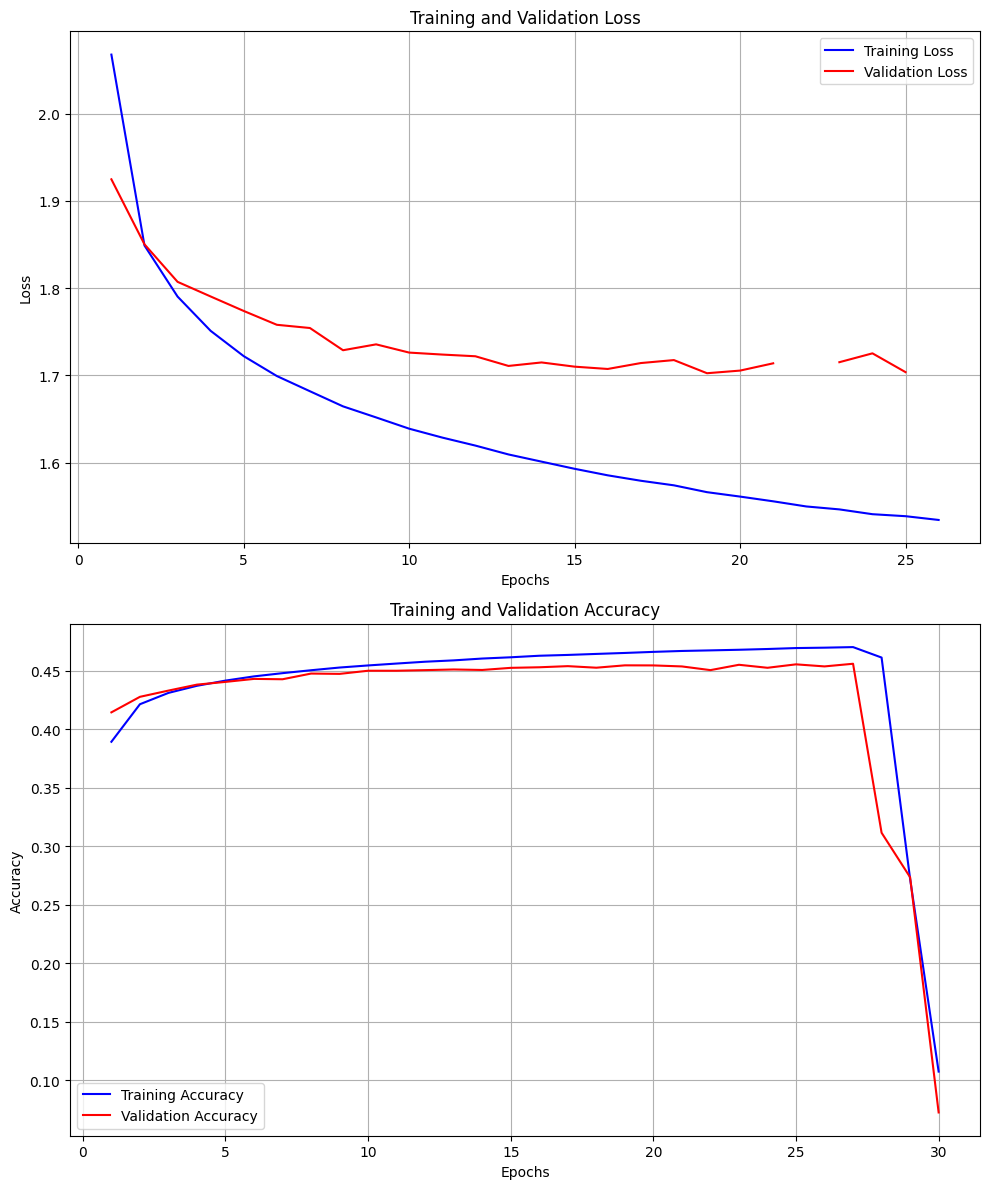

Final Training Loss: nan
Final Validation Loss: nan
Final Training Accuracy: 0.1076
Final Validation Accuracy: 0.0727


In [ ]:
# Extract metrics
train_losses = checkpoint['train_losses']
val_losses = checkpoint['val_losses']
train_accuracies = checkpoint['train_accuracies']
val_accuracies = checkpoint['val_accuracies']

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plot losses
epochs = range(1, len(train_losses) + 1)
ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot accuracies
ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
ax2.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the plot
plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# Print final metrics
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")
print(f"Final Training Accuracy: {train_accuracies[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")

In [ ]:
# Create sample inputs for summary
batch_size = 1
channels = 3
image_height = 224
image_width = 224
seq_length = 50  # typical sequence length for captions

# Generate sample inputs
sample_image = torch.zeros(batch_size, channels, image_height, image_width)
sample_captions = torch.zeros(batch_size, seq_length, dtype=torch.long)
sample_padding_mask = torch.ones(batch_size, seq_length, dtype=torch.long)  # Added padding mask

# Model Summary
summary(caption_model, 
        input_data=[
            sample_image.to(device), 
            sample_captions.to(device),
            sample_padding_mask.to(device)  # Added padding mask
        ],
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"],
        depth=5)

Layer (type (var_name))                                                Input Shape          Output Shape         Param #              Trainable
TransformerImageCaptioningModel (TransformerImageCaptioningModel)      [1, 3, 224, 224]     [1, 50, 30522]       --                   Partial
├─CNNEncoder (encoder)                                                 --                   [1, 49, 512]         --                   Partial
│    └─Sequential (resnet)                                             [1, 3, 224, 224]     [1, 2048, 7, 7]      --                   False
│    │    └─Conv2d (0)                                                 [1, 3, 224, 224]     [1, 64, 112, 112]    (9,408)              False
│    │    └─BatchNorm2d (1)                                            [1, 64, 112, 112]    [1, 64, 112, 112]    (128)                False
│    │    └─ReLU (2)                                                   [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --
│    │    └─Max

In [ ]:
# Concise summary
summary(caption_model, 
        input_data=[
            sample_image.to(device), 
            sample_captions.to(device),
            sample_padding_mask.to(device)  # Added padding mask
        ],
        depth=2,  # Reduce depth to show less nested layers
        verbose=0,  # Reduce verbosity
        col_names=["output_size", "num_params"],  # Show only essential columns
        row_settings=["var_names"])

Layer (type (var_name))                                                Output Shape              Param #
TransformerImageCaptioningModel (TransformerImageCaptioningModel)      [1, 50, 30522]            --
├─CNNEncoder (encoder)                                                 [1, 49, 512]              --
│    └─Sequential (resnet)                                             [1, 2048, 7, 7]           (23,508,032)
│    └─Conv2d (conv_reduce)                                            [1, 512, 7, 7]            1,049,088
├─Decoder (decoder)                                                    [1, 50, 30522]            --
│    └─Embedding (embedding)                                           [1, 50, 512]              15,627,264
│    └─SinusoidalPosEmb (pos_emb)                                      [50, 512]                 --
│    └─ModuleList (blocks)                                             --                        25,224,192
│    └─Linear (fc_out)                                        

## Evaluating Model on BLEU and CIDEr

The model with the lowest validation (best epoch) is evaluated using BLEU and CIDEr metrics in image captioning. The evaluation process involves:

1. **Data Collection**:
   - Keep track of unique image IDs to avoid duplicate processing
   - For each unique image:
     * Generate a model caption
     * Get all human reference captions from COCO dataset

2. **Score Calculation**:
   - For each unique image:
     * Compare model's caption with all human reference captions
     * Calculate BLEU-1 to BLEU-4, and CIDEr scores
   - Average all scores across the validation dataset

3. **Saving Results**:
   - Save all scores to a JSON file for later analysis
   - Record separate scores for each evaluation metric

In [ ]:
# Load best weights
checkpoint_path = 'data/cnn+custom transformer_best_model.pth'  # Adjust path as needed
checkpoint = torch.load(checkpoint_path, map_location=device)
    
# Load model weights
caption_model.load_state_dict(checkpoint['model_state_dict'])

# Load optimizer state
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Check val loss
print(checkpoint['val_losses'])

C:\Users\Irfaan\AppData\Local\Temp\ipykernel_23932\2994081863.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=devic

[1.9247959458919437, 1.8502256583679668, 1.8072132003276855, 1.7904186980498722, 1.7738121403452685, 1.7579592341352301, 1.754264655930307, 1.7287803708439897, 1.7355220238570972, 1.7260779651534526, 1.723815761868606, 1.7218676320732098, 1.7107720338475063, 1.7147756903372762, 1.7099403322810103, 1.7072972446451407, 1.7140826056985294, 1.7174843400335678, 1.7024144321451407]


In [ ]:
print(f"Best Epoch is: {checkpoint['epoch']}")

Best Epoch is: 19


In [ ]:
# Using nltk
bleu_scores = calculate_bleu_scores(
                model=caption_model,
                data_loader=data_loader_val,
                tokenizer=tokenizer,
                device=device,
                temperature=0.5
            )
# Print the scores
print("\nEvaluation Results:")
print("-" * 50)
for metric, score in bleu_scores.items():
    print(f"{metric.upper():<10}: {score:.4f}")

Calculating BLEU scores:   0%|                                                                 | 0/782 [00:00<?, ?it/s]C:\Users\Irfaan\AppData\Local\Temp\ipykernel_26440\1291174270.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
Calculating BLEU scores: 100%|███████████████████████████████████████████████████████| 782/782 [43:48<00:00,  3.36s/it]



Evaluation Results:
--------------------------------------------------
BLEU-1    : 0.6919
BLEU-2    : 0.4888
BLEU-3    : 0.3450
BLEU-4    : 0.2384


In [ ]:
def calculate_bleu_cider_scores(model, data_loader, tokenizer, device, max_length=50, temperature=0.5):
    """Calculate scores using COCO evaluation metrics"""
    model.eval()
    refs = {}
    hypos = {}
    
    # Initialize scorers
    scorers = [
        (Bleu(4), ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4"]),
        (Cider(), "CIDEr")
    ]

    
    with torch.no_grad():
        eval_progress = tqdm.tqdm(data_loader, desc='Generating captions')
        for images, _, img_ids in eval_progress:
            images = images.to(device)
            
            # Generate captions for batch
            for i, img in enumerate(images):
                img_id = img_ids[i].item()
                img_id_str = str(img_id)
                
                # Skip if we already processed this image
                if img_id_str in refs:
                    continue
                
                # Generate caption for the image
                output_ids = generate_caption(model, img, tokenizer, device, max_length, temperature)
                predicted_caption = tokenizer.decode(output_ids, skip_special_tokens=True)
                
                # Get all reference captions for this image from COCO
                ann_ids = data_loader.dataset.coco.getAnnIds(imgIds=img_id)
                anns = data_loader.dataset.coco.loadAnns(ann_ids)
                reference_captions = [ann['caption'].lower() for ann in anns]
                
                # Store references and hypothesis
                refs[img_id_str] = reference_captions
                hypos[img_id_str] = [predicted_caption]
    
    # Calculate scores
    scores = {}
    print("\nCalculating scores...")
    for scorer, method in scorers:
        print(f'Computing {method}...')
        score, scores_per_caption = scorer.compute_score(refs, hypos)
        if isinstance(method, list):
            for sc, m in zip(score, method):
                scores[m] = sc
        else:
            scores[method] = score
    
    return scores

def evaluate_metrics(model, data_loader, tokenizer, device, max_samples=None):
    """
    Evaluate model using COCO evaluation metrics
    """
    model.eval()
    
    # Create a smaller dataloader if max_samples is specified
    if max_samples:
        subset_indices = list(range(min(max_samples, len(data_loader.dataset))))
        subset_dataset = torch.utils.data.Subset(data_loader.dataset, subset_indices)
        data_loader = DataLoader(subset_dataset, 
                               batch_size=data_loader.batch_size,
                               shuffle=False,
                               num_workers=data_loader.num_workers)
    
    print("Starting evaluation...")
    scores = calculate_bleu_cider_scores(model, 
                                 data_loader,
                                 tokenizer,
                                 device)
    
    # Print results
    print("\nEvaluation Scores:")
    print("=" * 50)
    for metric, score in scores.items():
        print(f"{metric:<10}: {score:.4f}")
    print("=" * 50)
    
    # Calculate number of processed images
    processed_images = len(data_loader.dataset)
    print(f"\nEvaluated on {processed_images} images")
    
    return scores

In [ ]:
print("Starting evaluation...")
val_scores = evaluate_metrics(caption_model, 
                            data_loader_val,
                            tokenizer,
                            device)  
# Save results
results = {
    'scores': val_scores,
    'timestamp': time.strftime("%Y%m%d-%H%M%S"),
}
with open('evaluation_results_best.json', 'w') as f:
    json.dump(results, f, indent=4)

Starting evaluation...
Starting evaluation...


Generating captions:   0%|                                                                     | 0/782 [00:00<?, ?it/s]C:\Users\Irfaan\AppData\Local\Temp\ipykernel_23932\1291174270.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
Generating captions: 100%|███████████████████████████████████████████████████████████| 782/782 [10:30<00:00,  1.24it/s]



Calculating scores...
Computing ['Bleu_1', 'Bleu_2', 'Bleu_3', 'Bleu_4']...
{'testlen': 50541, 'reflen': 49379, 'guess': [50541, 45541, 40541, 35541], 'correct': [32340, 14764, 6040, 2541]}
ratio: 1.0235322708033574
Computing CIDEr...

Evaluation Scores:
Bleu_1    : 0.6399
Bleu_2    : 0.4555
Bleu_3    : 0.3138
Bleu_4    : 0.2168
CIDEr     : 0.6462

Evaluated on 25014 images


## Image Visualization and Caption Analysis

Comprehensive visualization utilities for model evaluation:

1. **Image Visualization**:
   - Denormalization for proper image display
   - Tensor to numpy conversion
   - Display formatting

2. **Caption Analysis**:
   - Side-by-side comparison of actual vs predicted captions
   - Multiple reference captions display
   - Metric scores for individual predictions


Generating sample visualizations...


C:\Users\Irfaan\AppData\Local\Temp\ipykernel_23932\1291174270.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


{'testlen': 13, 'reflen': 10, 'guess': [13, 12, 11, 10], 'correct': [11, 5, 1, 0]}
ratio: 1.2999999998700003


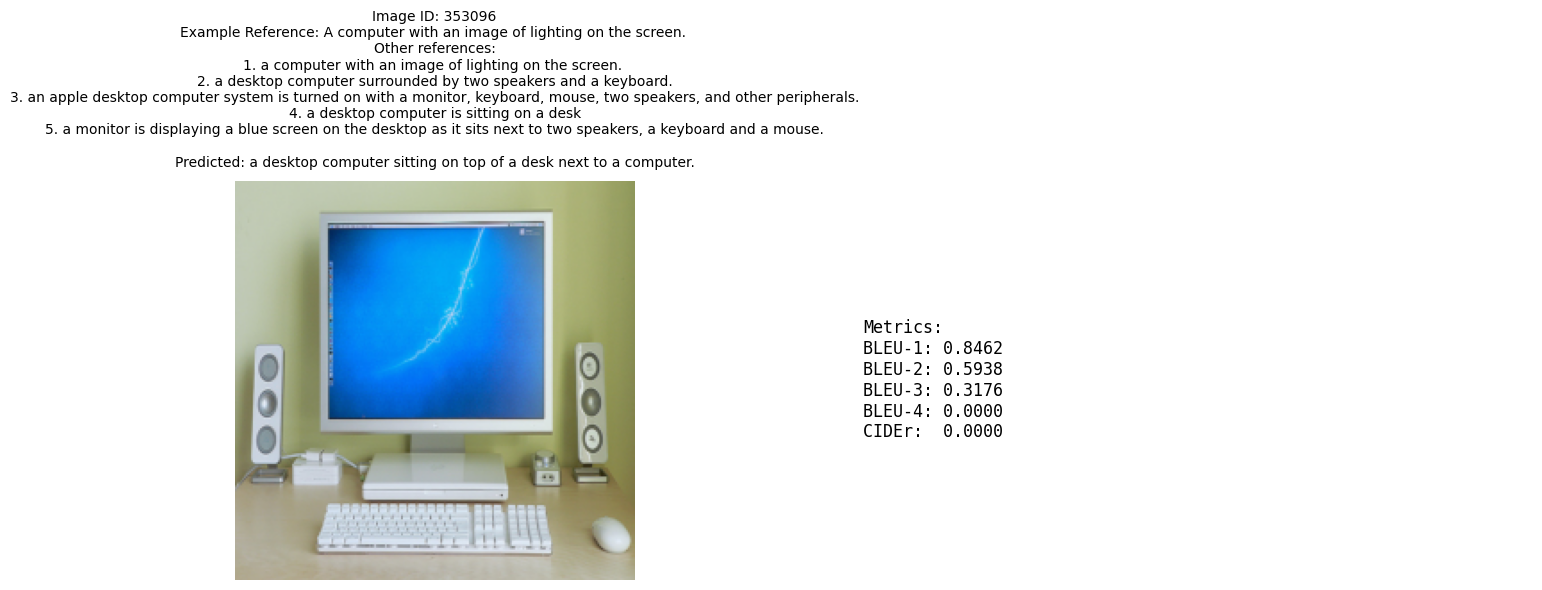

{'testlen': 11, 'reflen': 11, 'guess': [11, 10, 9, 8], 'correct': [8, 5, 2, 1]}
ratio: 0.999999999909091


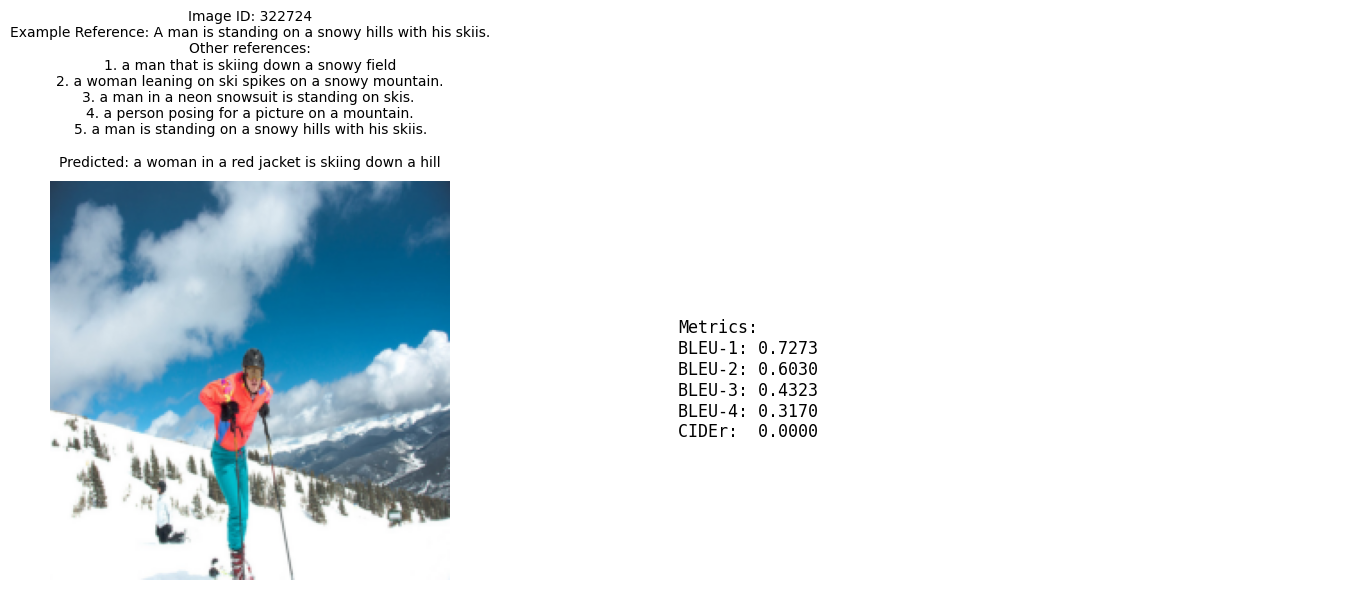

{'testlen': 11, 'reflen': 11, 'guess': [11, 10, 9, 8], 'correct': [9, 5, 3, 2]}
ratio: 0.999999999909091


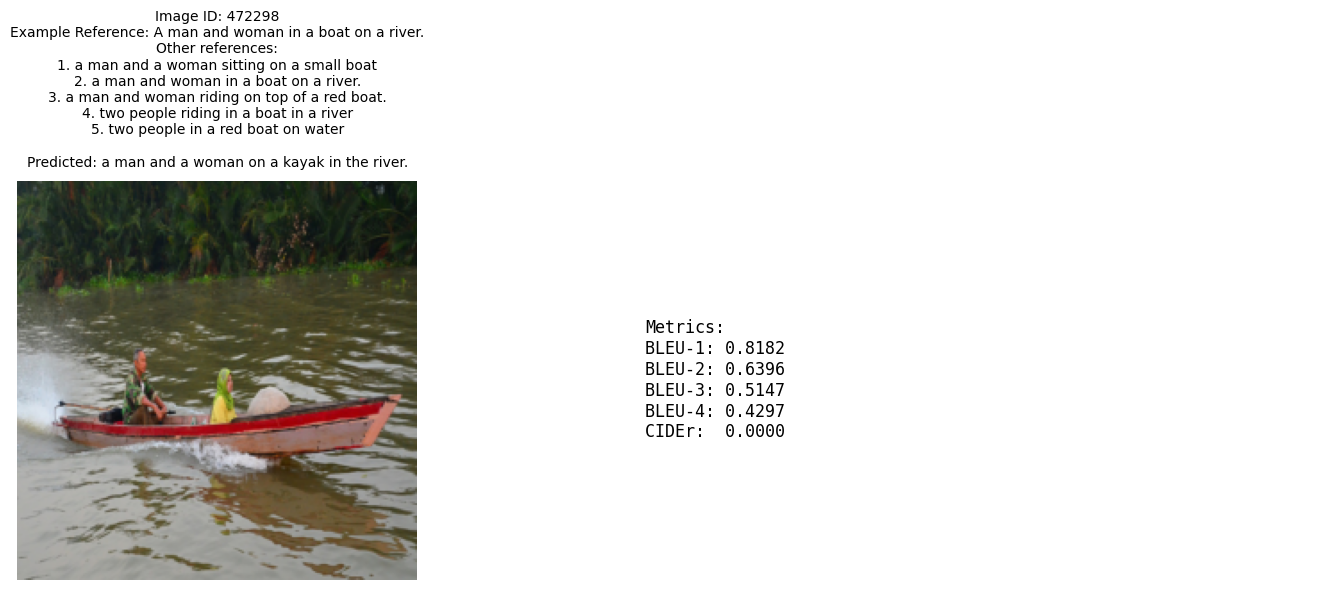

In [ ]:
def denormalize_image(image):
    """Denormalize image from [-1, 1] range to [0, 1] range"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(image.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(image.device)
    
    img = image * std + mean
    img = torch.clamp(img, 0, 1)
    return img

def calculate_single_caption_metrics(predicted_caption, reference_captions):
    """Calculate metrics for a single caption"""
    scorers = [
        (Bleu(4), ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4"]),
        (Cider(), "CIDEr")
    ]
    
    refs = {'0': reference_captions}
    hypos = {'0': [predicted_caption]}
    
    scores = {}
    for scorer, method in scorers:
        score, _ = scorer.compute_score(refs, hypos)
        if isinstance(method, list):
            for sc, m in zip(score, method):
                scores[m] = sc
        else:
            scores[method] = score
            
    return scores

def visualize_sample(image, actual_caption, all_captions, predicted_caption, img_id=None):
    """Visualize a single sample with metrics"""
    plt.figure(figsize=(15, 6))
    
    # Image and captions subplot
    plt.subplot(1, 2, 1)
    img_denorm = denormalize_image(image)
    plt.imshow(img_denorm.cpu().permute(1, 2, 0).numpy())
    
    # Calculate metrics
    scores = calculate_single_caption_metrics(predicted_caption, all_captions)
    
    # Create title with image ID and captions
    title = f'Image ID: {img_id.item()}\n' if img_id is not None else ''
    title += f'Example Reference: {actual_caption}\n'
    title += f'Other references:\n'
    for i, cap in enumerate(all_captions, 1):
        title += f'{i}. {cap}\n'
    title += f'\nPredicted: {predicted_caption}'
    
    plt.title(title, fontsize=10, pad=10)
    plt.axis('off')
    
    # Metrics subplot
    metrics_text = (
        f"Metrics:\n"
        f"BLEU-1: {scores['Bleu_1']:.4f}\n"
        f"BLEU-2: {scores['Bleu_2']:.4f}\n"
        f"BLEU-3: {scores['Bleu_3']:.4f}\n"
        f"BLEU-4: {scores['Bleu_4']:.4f}\n"
        f"CIDEr:  {scores['CIDEr']:.4f}"
    )
    plt.subplot(1, 2, 2)
    plt.text(0.1, 0.5, metrics_text, 
             fontsize=12, family='monospace',
             verticalalignment='center')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def visualize_multiple_samples(model, dataloader, num_samples=3):
    """Visualize multiple samples with their actual and predicted captions"""
    model.eval()
    
    for _ in range(num_samples):
        # Get a sample
        image, caption, img_id = next(iter(dataloader))
        image = image[0].to(device)
        
        # Get reference captions using COCO API
        reference_captions = []
        ann_ids = dataloader.dataset.coco.getAnnIds(imgIds=img_id[0].item())
        anns = dataloader.dataset.coco.loadAnns(ann_ids)
        reference_captions = [ann['caption'].lower() for ann in anns]
        
        # Generate predicted caption
        output_ids = generate_caption(model, image, tokenizer, device, 50, 0.5)
        predicted_caption = tokenizer.decode(output_ids, skip_special_tokens=True)
        
        # Visualize the sample
        visualize_sample(image, caption[0], reference_captions, predicted_caption, img_id[0])

# Visualize some samples
print("\nGenerating sample visualizations...")
visualize_multiple_samples(caption_model, data_loader_val, num_samples=3)